# Useful ressource:

https://www.dlology.com/blog/how-to-do-unsupervised-clustering-with-keras/

Method:
- We train an autoencoder to encode samples in the latent space
- We create a new encoder, with a clustering layer at the end of it --> we assess if the clustering is correct
- We train a new autoencoder, this time with the **Latent Clustered Layer** included: one **clustered model** as encoder, and a classic decoder

Countefactual part:
- We get a sample from class I and we encode it with the **clustered model**
- We choose a class K, and we get the normal distribution of its samples in the **Clustered Layer**
- We generate new samples with **multivariate_normal**
- We get in the **Latent Clustered Layer** the closest neighbor among generated samples to the sample from class I

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import datasets
from matplotlib import pyplot as plt

import keras
from keras import layers
from keras import backend as K

<h3> Loading MNIST </h3>

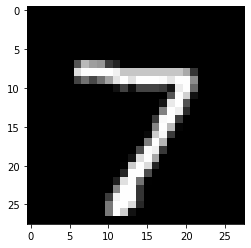

In [2]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))

x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255.)

plt.imshow(x_test[0].reshape(28, 28), cmap='gray')

# Callbacks functions

In [3]:
from IPython.display import clear_output
from keras.callbacks import EarlyStopping


class PlotLosses(keras.callbacks.Callback):
    def __init__(self, plot_interval=1, evaluate_interval=10, x_val=None, y_val_categorical=None):
        self.plot_interval = plot_interval
        self.evaluate_interval = evaluate_interval
        self.x_val = x_val
        self.y_val_categorical = y_val_categorical
    def on_train_begin(self, logs={}):
        print('Begin training')
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        if self.evaluate_interval is None:
            self.logs.append(logs)
            self.x.append(self.i)
            self.losses.append(logs.get('loss'))
            self.val_losses.append(logs.get('val_loss'))
            self.acc.append(logs.get('accuracy'))
            self.val_acc.append(logs.get('val_accuracy'))
            self.i += 1
        if (epoch%self.plot_interval==0):
            clear_output(wait=True)
            f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(20,5))
            ax1.plot(self.x, self.losses, label="loss")
            ax1.plot(self.x, self.val_losses, label="val_loss")
            ax1.legend()
            ax2.plot(self.x, self.acc, label="acc")
            ax2.plot(self.x, self.val_acc, label="val_acc")
            ax2.legend()
            plt.show();
    def on_batch_end(self, batch, logs={}):
        if self.evaluate_interval is not None:
            if (batch%self.evaluate_interval==0):
                self.i += 1
                self.logs.append(logs)
                self.x.append(self.i)
                self.losses.append(logs.get('loss'))
                self.acc.append(logs.get('acc'))
                if self.x_val is not None:
                    score = self.model.evaluate(self.x_val, self.y_val_categorical, verbose=0)
                    self.val_losses.append(score[0])
                    self.val_acc.append(score[1])

plot_losses = PlotLosses(plot_interval = 1, evaluate_interval = None)

# Autoencoder, with a clustering layer to better split the different classes in the Latent Layer:

In [4]:
from keras.layers import Layer
from keras.layers import InputSpec

class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label.
    
    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.        
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

<h3> Loading data </h3>

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [6]:
x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))

<h3> Pre-train autoencoder: configuring models </h3>

In [7]:
original_dim = 28 * 28
intermediate_dim_1 = 500
intermediate_dim_2 = 1000
latent_dim = 10

inputs = keras.Input(shape=(original_dim,))
h1 = layers.Dense(intermediate_dim_1, activation='relu')(inputs)
h2 = layers.Dense(intermediate_dim_2, activation='relu')(h1)
encoded = layers.Dense(latent_dim)(h2)

# Create encoder
encoder = keras.Model(inputs, encoded, name='encoder')

In [8]:
# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,))
d1 = layers.Dense(intermediate_dim_1, activation='relu')(latent_inputs)
d2 = layers.Dense(intermediate_dim_2, activation='relu')(d1)
decoded = layers.Dense(original_dim, activation='sigmoid')(d2)

decoder = keras.Model(latent_inputs, decoded, name='decoder')

In [9]:
# instantiate VAE model
outputs = decoder(encoder(inputs))
autoencoder = keras.Model(inputs, outputs, name='vae')

In [10]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

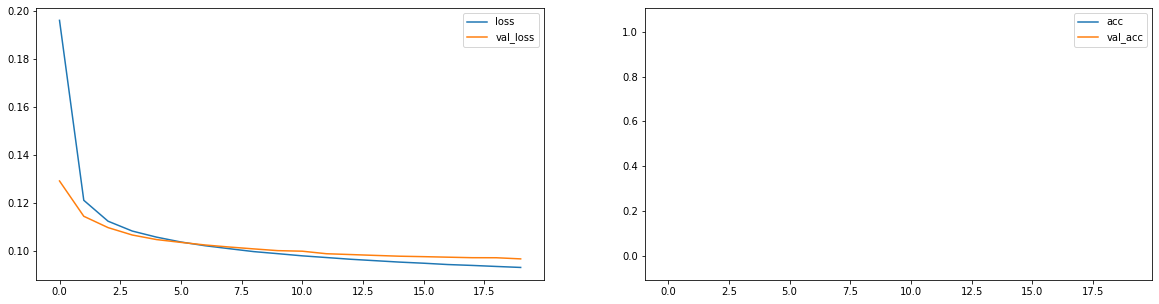

235/235 [==============================] - 14s 58ms/step - loss: 0.0932 - val_loss: 0.0967


In [11]:
autoencoder.fit(x_train, x_train, batch_size=256, epochs=20, 
                validation_data = (x_test, x_test),
               callbacks=[plot_losses, EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

**Example of representation with the autoencoder**

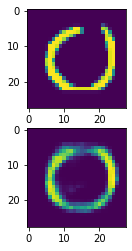

In [12]:
nb_sample = np.random.randint(x_test.shape[1], size=1)

ax = plt.subplot(2, 1, 1)
plt.imshow(x_test[nb_sample].reshape(28, 28))

ax = plt.subplot(2, 1, 2)
plt.imshow(autoencoder.predict(x_test[None, nb_sample]).reshape(28, 28))

<h3> Adding clustering to the model </h3>

In [13]:
n_clusters = 10

In [14]:
clustering_layer = ClusteringLayer(n_clusters, name="clustering")(encoder.output)

In [15]:
from keras import Model
from sklearn.cluster import KMeans

clustering_model = Model(inputs=encoder.input, outputs=clustering_layer)
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))

In [16]:
kmeans.cluster_centers_

array([[ -0.56065464,  -2.167051  ,  -4.1079454 ,   3.3856578 ,
         -4.9373045 ,  -3.5616307 ,  -5.2748837 ,  -6.7731943 ,
          5.2529    ,  -5.9097185 ],
       [ -9.802187  ,   4.6016808 ,  -1.355408  ,   5.5200033 ,
          1.8200009 ,  -1.9815869 ,   7.6590323 ,  -3.1608133 ,
          0.3364315 ,   2.8144886 ],
       [  3.2996209 ,  -6.0244102 , -11.455967  ,  -6.843905  ,
          2.553093  , -12.645212  , -11.305645  ,  -4.0265026 ,
          0.44939232,   3.7057512 ],
       [  1.0566294 ,  -1.1260281 ,  -2.1062446 ,  -6.8105307 ,
          9.368481  ,  -5.726061  ,   2.8844674 ,  -4.817274  ,
          8.056922  ,   2.6323936 ],
       [ -5.396237  ,  -8.259047  ,   4.6842923 ,  -6.8098454 ,
          0.3966937 ,   0.757586  ,  -0.19817305, -10.494911  ,
          3.5158849 ,  10.798     ],
       [ -0.7046145 ,  -3.194539  ,  -0.7158444 ,   0.94853723,
          1.4278126 ,  -7.840107  ,   1.8764999 ,   2.571219  ,
         -4.9304695 ,   0.19391298],
       [  

In [17]:
clustering_model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

In [19]:
clustering_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 500)               392500    
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              501000    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                10010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 10)                100       
Total params: 903,610
Trainable params: 903,610
Non-trainable params: 0
_________________________________________________________________


<h3> Training the clustering model </h3>

In [20]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [21]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score


def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [22]:
index_array = np.arange(x_train.shape[0])
index = 0
batch_size = 256

In [23]:
from keras.optimizers import SGD
from sklearn.metrics import accuracy_score
from tqdm import tqdm

clustering_model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

maxiter = 500
update_interval = 100
for ite in tqdm(range(int(maxiter))):
    if ite % update_interval == 0:
        q = clustering_model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p
        # evaluate the clustering performance
        y_pred = q.argmax(1)
        print('pred is', y_pred)
        if y is not None:
            acc = np.round(accuracy_score(y, y_pred), 5)

    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = clustering_model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

  0%|          | 0/500 [00:00<?, ?it/s]

pred is [5 1 4 ... 9 5 7]


 21%|██        | 106/500 [00:15<01:53,  3.47it/s]

pred is [5 1 4 ... 9 5 7]


 41%|████      | 205/500 [00:24<01:56,  2.53it/s]

pred is [5 1 4 ... 9 5 7]


 62%|██████▏   | 308/500 [00:32<00:45,  4.18it/s]

pred is [5 1 4 ... 9 5 7]


 81%|████████  | 405/500 [00:42<00:30,  3.16it/s]

pred is [5 1 4 ... 9 5 7]


100%|██████████| 500/500 [00:44<00:00, 11.21it/s]


In [24]:
from sklearn.utils.linear_assignment_ import linear_assignment

y_true = y.astype(np.int64)
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
# Confusion matrix.
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(-w)
acc = sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [25]:
acc

0.8098571428571428

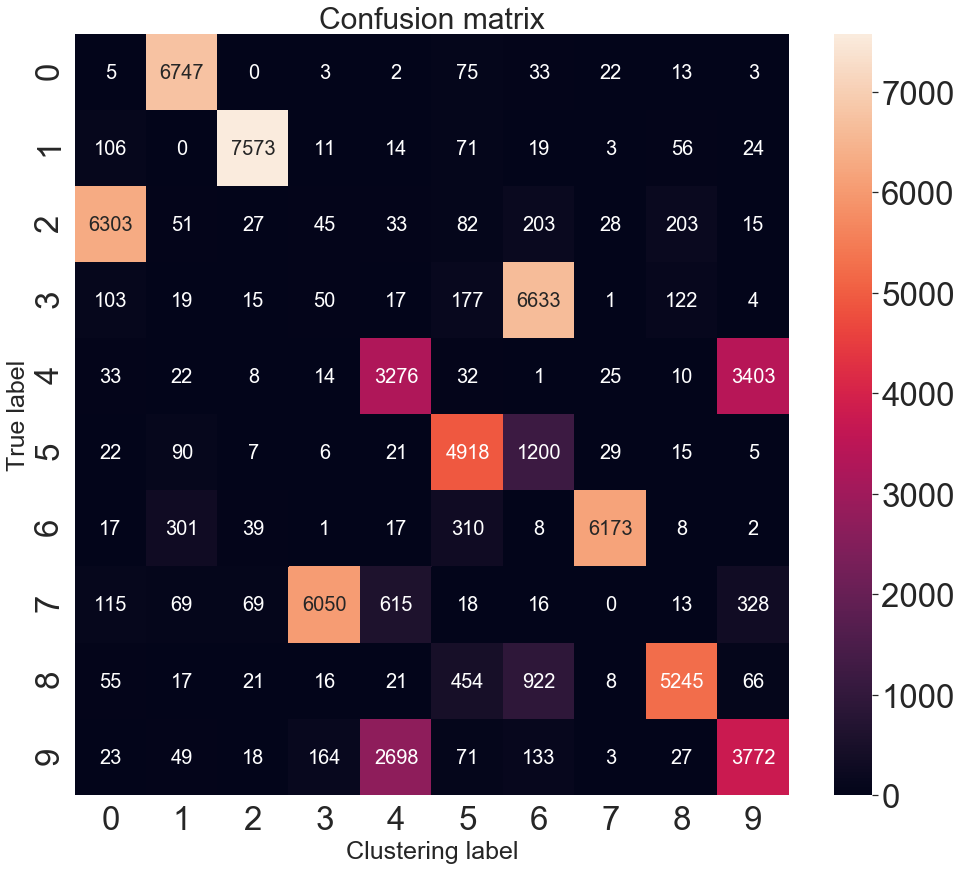

In [26]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

# Training the whole autoencoder with clustering layer

The Dlology article first trains the whole autoencoder without clustering layer, then adds the clustering layer to the encoder and trains the encoder alone.

In this part, I recreate a whole autoencoder that already includes the clustering layer as **latent layer**, therefore the decoder is already trained to reconstruct images from the clustering latent layer (vs previous case where the decoder was trained to **reconstruct images from a Dense Latent Layer only**)

In [27]:
# Create decoder from clustering layer
latent_inputs = keras.Input(shape=(latent_dim,))
d1 = layers.Dense(intermediate_dim_1, activation='relu')(latent_inputs)
d2 = layers.Dense(intermediate_dim_2, activation='relu')(d1)
decoded_clustering = layers.Dense(original_dim, activation='sigmoid')(d2)

decoder_clustering = keras.Model(latent_inputs, decoded_clustering, name='decoder_clustering')

In [28]:
# instantiate VAE model
outputs_clustering = decoder_clustering(clustering_model(inputs))
autoencoder_clustering = keras.Model(inputs, outputs_clustering, name='vae')

In [29]:
autoencoder_clustering.compile(optimizer='adam', loss='binary_crossentropy')

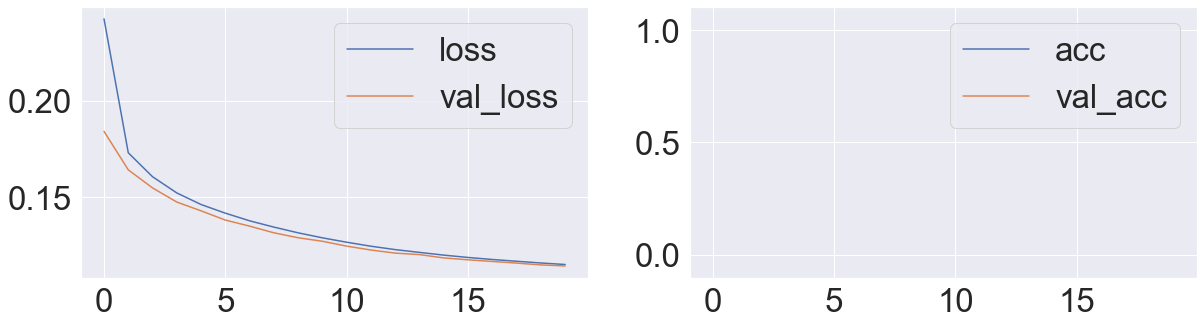

235/235 [==============================] - 12s 51ms/step - loss: 0.1153 - val_loss: 0.1145


In [30]:
autoencoder_clustering.fit(x_train, x_train, batch_size=256, epochs=20, 
                validation_data = (x_test, x_test),
               callbacks=[plot_losses, EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

**Testing the autoencoder with the cluster layer:**

[[0.09358203 0.08890628 0.09904588 0.08264218 0.10911329 0.09137205
  0.14799796 0.08444518 0.11521138 0.08768381]]


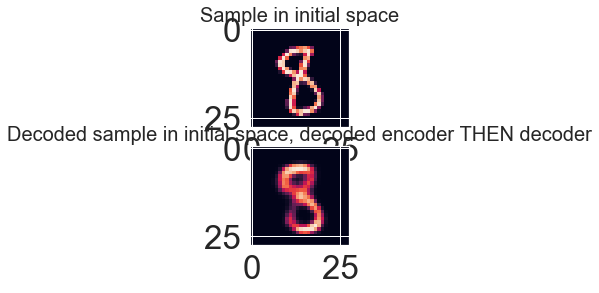

In [31]:
ind_sample = np.random.randint(x.shape[0], size=1)[0]

plt.subplot(2, 1, 1)
plt.title("Sample in initial space", fontsize=20)
plt.imshow(x[ind_sample].reshape(28, 28))

plt.subplot(2, 1, 2)
encoded_sample = clustering_model.predict(x[None, ind_sample])
print(encoded_sample)
decoded_clustering = decoder_clustering.predict(encoded_sample)
plt.title("Decoded sample in initial space, decoded encoder THEN decoder", fontsize=20)
plt.imshow(decoded_clustering.reshape(28, 28))

<h3> Selecting one class and generating samples of this class </h3>

We want to generate samples from class **class_to_generate**

In [32]:
confusion_matrix

array([[   5, 6747,    0,    3,    2,   75,   33,   22,   13,    3],
       [ 106,    0, 7573,   11,   14,   71,   19,    3,   56,   24],
       [6303,   51,   27,   45,   33,   82,  203,   28,  203,   15],
       [ 103,   19,   15,   50,   17,  177, 6633,    1,  122,    4],
       [  33,   22,    8,   14, 3276,   32,    1,   25,   10, 3403],
       [  22,   90,    7,    6,   21, 4918, 1200,   29,   15,    5],
       [  17,  301,   39,    1,   17,  310,    8, 6173,    8,    2],
       [ 115,   69,   69, 6050,  615,   18,   16,    0,   13,  328],
       [  55,   17,   21,   16,   21,  454,  922,    8, 5245,   66],
       [  23,   49,   18,  164, 2698,   71,  133,    3,   27, 3772]])

In [33]:
# Choosing the class to generate
class_to_generate = 2

# Finding the associated cluster in the confusion matrix
repartition_elements_in_latent_layer = confusion_matrix[class_to_generate]
id_cluster_in_latent_layer = np.argmax(repartition_elements_in_latent_layer)
print('ID of cluster is', id_cluster_in_latent_layer, ', it contains', 
      len(np.intersect1d(np.where(y == class_to_generate)[0], np.where(y_pred == id_cluster_in_latent_layer)[0])),
     'samples')


ID of cluster is 0 , it contains 6303 samples


We get the index of elements from latent layer that are in the cluster associated to the class that we want to generate.

We only select the samples that were correctly labelled in the same cluster

In [34]:
index_original_samples = np.where(y == class_to_generate)[0]
index_clustered_samples = np.where(y_pred == id_cluster_in_latent_layer)[0]

ind_class = np.intersect1d(index_original_samples, index_clustered_samples)
encoded_values_class = clustering_model.predict(x[ind_class])
encoded_values_class.shape

(6303, 10)

**Assessing whether the chosen samples decode the right class**

Text(0.5, 1.0, 'Digit 2')

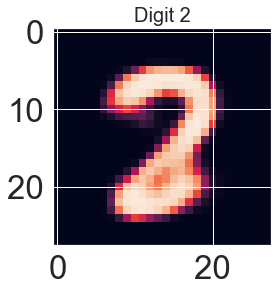

In [35]:
rand_sample_cluster_index = np.random.randint(encoded_values_class.shape[0], size=1)

plt.figure(figsize=(4, 4))
plt.imshow(decoder_clustering.predict(encoded_values_class[None, rand_sample_cluster_index]).reshape(28, 28))
plt.title(f'Digit {class_to_generate}', fontsize=20)

*We get the right digit displayed*

**For this class, we get the mean of the sample and the covariance matrix**

In [36]:
mean = np.mean(encoded_values_class, axis=0)
covs = np.array(pd.DataFrame(encoded_values_class).cov())
print('shape of mean is', mean.shape, '\n shape of covs is', covs.shape)
mean

shape of mean is (10,) 
 shape of covs is (10, 10)


array([0.14808322, 0.0933099 , 0.07892619, 0.09499837, 0.07783227,
       0.11104084, 0.10816448, 0.09417809, 0.11450387, 0.07896253],
      dtype=float32)

<h3> Getting the closest neighbor to an initial sample among the new samples </h3>

**Now we can generate samples following this distribution:**

In [37]:
additional_samples = np.random.multivariate_normal(mean, covs, size=1000)
additional_samples.shape, additional_samples

((1000, 10),
 array([[0.1562441 , 0.10778783, 0.05604012, ..., 0.08844883, 0.14480771,
         0.08456546],
        [0.1182251 , 0.1005222 , 0.04542394, ..., 0.07763434, 0.11912508,
         0.08181644],
        [0.13462126, 0.08759666, 0.06928013, ..., 0.08459936, 0.11911671,
         0.09674036],
        ...,
        [0.14920227, 0.08419799, 0.11580695, ..., 0.09534631, 0.11915421,
         0.08540477],
        [0.12512243, 0.08612932, 0.0868503 , ..., 0.1054859 , 0.15473164,
         0.05320283],
        [0.17531578, 0.07505579, 0.07597518, ..., 0.10654343, 0.09026191,
         0.07750764]]))

**Testing if one of the generated samples gives us the right number when decoded:**

[[0.16029217 0.09141924 0.04404224 0.09020788 0.09815154 0.10849752
  0.09652428 0.08206215 0.12621078 0.102592  ]]


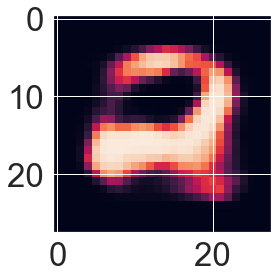

In [38]:
# Random sample among the additional samples
rand_sample_id = np.random.randint(additional_samples.shape[0], size=1)

rand_sample = additional_samples[rand_sample_id]
print(rand_sample)

decoded_sample = decoder_clustering.predict(rand_sample)
plt.imshow(decoded_sample.reshape(28, 28)  * 255)

*We get the right digit displayed*

**1/ We get a random sample from the initial space, and we encode it in the latent space**

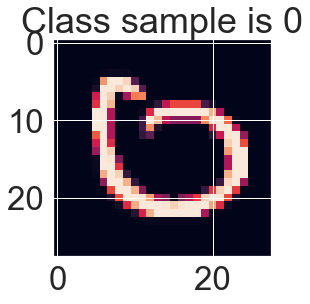

In [39]:
sample = pd.DataFrame(x).sample()

# Class of the sample:
ind_sample = sample.index
class_sample = list(y[ind_sample])[0]

plt.title('Class sample is ' + str(class_sample))
plt.imshow(np.array(sample).reshape(28, 28))

In [40]:
# We encode the sample in the latent layer
sample_in_latent_layer = clustering_model.predict(sample)
sample_in_latent_layer.shape, sample_in_latent_layer

((1, 10),
 array([[0.10818318, 0.18987596, 0.0575923 , 0.12479877, 0.09938686,
         0.07698941, 0.11871433, 0.10249443, 0.06250587, 0.0594589 ]],
       dtype=float32))

**2/ We find, in the latent space, the closest neighbor to our previous sample in the cluster of class class_to_generate**

In [41]:
# We get the closest neighbor of the previous random sample in the class cluster

closest_neighbor = additional_samples[np.argmin(np.linalg.norm(sample_in_latent_layer - additional_samples, axis=1))]
closest_neighbor

array([0.11276282, 0.11144941, 0.06379646, 0.12482579, 0.10062044,
       0.10862157, 0.1038515 , 0.09428377, 0.09769477, 0.08209318])

**3/ We decode the closest neighbor in the output space**

Text(0.5, 1.0, 'Closest neigbor of class 0 among class 2 generated samples')

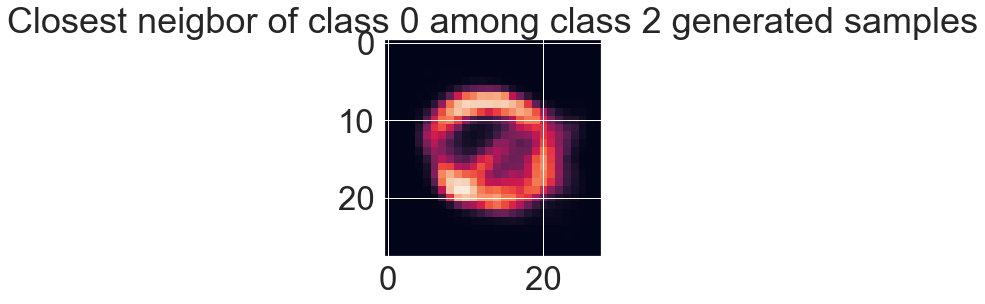

In [42]:
decoded_prediction = decoder_clustering.predict(closest_neighbor[None, :])
reconstructed_picture = decoded_prediction.reshape(28, 28)
plt.imshow(reconstructed_picture)
plt.title(f'Closest neigbor of class {class_sample} among class {class_to_generate} generated samples')

# Functions to get clusters parameters:

<h3> Creating the autoencoder network </h3>

**Training the first autoencoder**

In [43]:
def training_model(original_dim, intermediate_dim_1, intermediate_dim_2, latent_dim, data, batch_size, epochs):
    """
    Create a 4 layer autoencoder and train it
    
    """
    # Create encoder
    inputs = keras.Input(shape=(original_dim,))
    h1 = layers.Dense(intermediate_dim_1, activation='relu')(inputs)
    h2 = layers.Dense(intermediate_dim_2, activation='relu')(h1)
    encoded = layers.Dense(latent_dim)(h2)
    
    encoder = keras.Model(inputs, encoded, name='encoder')
    
    # Create decoder
    latent_inputs = keras.Input(shape=(latent_dim,))
    d1 = layers.Dense(intermediate_dim_1, activation='relu')(latent_inputs)
    d2 = layers.Dense(intermediate_dim_2, activation='relu')(d1)
    decoded = layers.Dense(original_dim, activation='sigmoid')(d2)

    decoder = keras.Model(latent_inputs, decoded, name='decoder')    

    # instantiate AE model
    outputs = decoder(encoder(inputs))
    autoencoder = keras.Model(inputs, outputs, name='vae')
    
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    autoencoder.fit(data, data, batch_size=batch_size, epochs=epochs, 
               callbacks=[EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)])
    return (encoder, decoder, autoencoder)
    

In [44]:
encoder_func, decoder_func, autoencoder_func = training_model(784, 500, 100, 10, x, 256, 10)

Epoch 1/10
274/274 [==============================] - 4s 14ms/step - loss: 0.2251
Epoch 2/10
274/274 [==============================] - 4s 13ms/step - loss: 0.1425
Epoch 3/10
274/274 [==============================] - 4s 13ms/step - loss: 0.1294
Epoch 4/10
274/274 [==============================] - 4s 13ms/step - loss: 0.1231
Epoch 5/10
274/274 [==============================] - 4s 13ms/step - loss: 0.1189
Epoch 6/10
274/274 [==============================] - 3s 13ms/step - loss: 0.1162
Epoch 7/10
274/274 [==============================] - 4s 13ms/step - loss: 0.1143
Epoch 8/10
274/274 [==============================] - 4s 14ms/step - loss: 0.1127
Epoch 9/10
274/274 [==============================] - 4s 15ms/step - loss: 0.1114
Epoch 10/10
274/274 [==============================] - 4s 15ms/step - loss: 0.1104


**Training the second autoencoder with clustering layer**

In [45]:
def clustering_samples(n_clusters, encoder, decoder, data, batch_size, epochs):
    """
    Adding cluster layer to encoder of autoencoder
    We assume the encoder and decoder have 4 layers each without the clustering layer
    
    n_clusters: number of possible classes (eg 10 for MNIST)
    x: data on which the clustering layer and new autoencoder are trained
    """
    from keras import Model
    from sklearn.cluster import KMeans
    
    clustering_layer = ClusteringLayer(n_clusters, name="clustering")(encoder.output)
    
    clustering_model = Model(inputs=encoder.input, outputs=clustering_layer)
    kmeans = KMeans(n_clusters=n_clusters, n_init=20)
    y_pred = kmeans.fit_predict(encoder.predict(data))
    
    clustering_model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
    
    # Create decoder from clustering layer
    latent_dim = encoder.output_shape[1]
    latent_inputs = keras.Input(shape=(latent_dim,))
    d1 = layers.Dense(decoder.layers[1].output_shape[1], activation='relu')(latent_inputs)
    d2 = layers.Dense(decoder.layers[2].output_shape[1], activation='relu')(d1)
    decoded_clustering = layers.Dense(decoder.layers[3].output_shape[1], activation='sigmoid')(d2)

    decoder_clustering = keras.Model(latent_inputs, decoded_clustering, name='decoder_clustering')
    
    # Create AE model with clustering layer
    original_dim = encoder.layers[0].output_shape[0][1]
    keras.Input(shape=(original_dim,))
    outputs_clustering = decoder_clustering(clustering_model(inputs))
    autoencoder_clustering = keras.Model(inputs, outputs_clustering, name='vae')
    
    # Train model with clustering layer
    autoencoder_clustering.compile(optimizer='adam', loss='binary_crossentropy')
    autoencoder_clustering.fit(data, data, batch_size=batch_size, epochs=epochs, 
                               callbacks=[EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)])

    return (clustering_model, decoder_clustering, autoencoder_clustering)
    

In [46]:
clustering_model, decoder_clustering, autoencoder_clustering = clustering_samples(10, encoder_func, decoder_func, x, 256, 10)

Epoch 1/10
274/274 [==============================] - 4s 14ms/step - loss: 0.2894
Epoch 2/10
274/274 [==============================] - 4s 14ms/step - loss: 0.2177
Epoch 3/10
274/274 [==============================] - 4s 14ms/step - loss: 0.2007
Epoch 4/10
274/274 [==============================] - 4s 13ms/step - loss: 0.1901
Epoch 5/10
274/274 [==============================] - 4s 15ms/step - loss: 0.1818
Epoch 6/10
274/274 [==============================] - 4s 13ms/step - loss: 0.1757
Epoch 7/10
274/274 [==============================] - 5s 16ms/step - loss: 0.1668
Epoch 8/10
274/274 [==============================] - 5s 18ms/step - loss: 0.1615
Epoch 9/10
274/274 [==============================] - 5s 20ms/step - loss: 0.1584: 0s - loss: 0.158
Epoch 10/10
274/274 [==============================] - 7s 25ms/step - loss: 0.1558


<h3> First function: get cluster number from a sample </h3>

In [47]:
def get_cluster_from_samples(clustering_encoder, samples):
    """
    Get cluster number from a matrix of samples
    clustering_encoder input must be have the same dimension as the samples
    """
    return np.argmax(clustering_encoder.predict(samples), axis=1)

In [48]:
get_cluster_from_samples(clustering_model, x_test[0:30])

array([4, 2, 3, 0, 2, 3, 2, 2, 2, 1, 0, 2, 4, 0, 3, 0, 2, 4, 2, 2, 1, 2,
       2, 1, 2, 8, 4, 2, 0, 2])

<h3> Second function: Get the decoded centroid when given a class </h3>

In [49]:
from collections import defaultdict

def get_cluster_parameters(clustering_encoder, classes, data, label):
    """
    Get means and covs for each class in the clustering layer
    classes: list of all possible classes
    data & label: dataset from that helps us find the normal distribution parameters of each class
    """
    parameters = defaultdict(dict)

    for class_ in classes:
        index_class = np.where(label == class_)
        encoded_values_class = clustering_encoder.predict(data[index_class])
        mean = np.mean(encoded_values_class, axis=0)
        covs = np.array(pd.DataFrame(encoded_values_class).cov())
        parameters[class_] = [mean, covs]    
        
    return parameters

In [50]:
# Example with MNIST: 10 classes
classes = [i for i in range(10)]

parameters = get_cluster_parameters(clustering_model, classes, x, y)
parameters

defaultdict(dict,
            {0: [array([0.20741296, 0.16241981, 0.1177821 , 0.0542165 , 0.05858752,
                     0.08232307, 0.07784776, 0.03782024, 0.10595776, 0.09563188],
                    dtype=float32),
              array([[ 2.27213562e-03, -1.69719308e-03, -1.52660257e-04,
                      -2.92636544e-04, -2.04751388e-04,  1.88114594e-04,
                       8.66007081e-05,  7.24989605e-06,  7.91729933e-05,
                      -2.86032574e-04],
                     [-1.69719308e-03,  4.57339417e-03, -9.33634167e-04,
                       1.98600584e-04,  3.63674451e-05, -6.10757124e-04,
                      -1.05066172e-03, -2.48292799e-04, -1.97303365e-04,
                      -7.05199424e-05],
                     [-1.52660257e-04, -9.33634167e-04,  9.07970404e-04,
                       1.10129934e-04,  3.94954750e-05, -1.63819189e-04,
                       1.05376884e-04,  3.62633356e-05, -2.24219872e-04,
                       2.75097474e-04],
   

In [51]:
def class_to_centroid(class_ids, parameters_dict, decoder):
    """
    Get parameters of all element classes we have in a list, then decodes in output space
    
    class_ids: list of elements corresponding to the classes of the samples for which we want to get parameters
    parameters_dict: dictionary with parameters of all classes
    """
    means_samples = [parameters_dict[element][0] for element in class_ids]
    #return [parameters_dict[element] for element in class_ids]
    return [decoder.predict(means_samples[i][None, :]) for i in range(len(means_samples))]

In [52]:
# Example with 3 MNIST classes:
class_to_centroid([1, 1, 2], parameters, decoder_clustering)

[array([[5.13366313e-13, 3.12611197e-14, 3.30837584e-14, 6.61087992e-13,
         9.92802520e-13, 2.73815345e-12, 6.27051471e-13, 2.25052046e-14,
         6.88958493e-13, 4.48971887e-13, 9.38066248e-13, 4.71208020e-14,
         1.34965129e-12, 5.52330751e-11, 2.68527093e-11, 5.09596705e-13,
         3.14856987e-14, 1.30840391e-12, 3.05007820e-12, 1.17629742e-13,
         6.54924465e-13, 5.77994510e-12, 2.64466075e-13, 4.27368942e-13,
         3.37728651e-13, 5.36030530e-13, 3.36648981e-12, 2.21889971e-13,
         3.73477508e-12, 4.73759541e-13, 3.49380328e-13, 1.20393355e-12,
         1.07675240e-12, 1.73537476e-12, 7.58480223e-10, 7.64116756e-11,
         5.81450499e-10, 2.74916531e-11, 1.44666368e-09, 5.42862200e-10,
         2.43507188e-08, 1.40852405e-08, 2.30270221e-08, 2.21958800e-07,
         5.74609828e-07, 8.87889371e-07, 4.02635152e-07, 3.85471765e-07,
         2.25289071e-07, 5.38765299e-09, 9.00540642e-10, 5.95850843e-12,
         8.50030007e-13, 8.62672021e-13, 1.02978682

<h3> Third function: Get the decoded centroid when given a sample </h3>

In [53]:
def get_centroids_from_samples(clustering_encoder, decoder, samples):
    """
    Give an encoder model, samples, and get the decoded centroids of each of these samples.

    The function takes the samples from initial space,
    then it gets their cluster ID,
    then it returns the centroid for each of them
    """
    classes = get_cluster_from_samples(clustering_encoder, samples)
    return class_to_centroid(classes, parameters, decoder)

In [54]:
y_test[0:3]

array([7, 2, 1], dtype=uint8)

In [55]:
get_centroids_from_samples(clustering_model, decoder_clustering, x_test[0:3])

[array([[1.54502668e-08, 2.82257311e-08, 2.19220535e-08, 1.47891894e-08,
         2.86534387e-08, 3.80427743e-08, 4.41735892e-08, 1.40853746e-08,
         8.24181186e-08, 2.11061320e-08, 4.76393964e-08, 2.47022687e-08,
         3.06931838e-07, 1.51723702e-06, 3.22518787e-07, 3.47437457e-08,
         3.11633457e-08, 2.88567517e-08, 4.10597352e-08, 3.13535331e-08,
         4.65110723e-08, 2.05232809e-08, 2.79071095e-08, 2.49975987e-08,
         2.97433616e-08, 2.97547107e-08, 2.12397211e-08, 2.80343482e-08,
         4.94742451e-08, 4.12779499e-08, 5.58203119e-08, 4.07993070e-08,
         9.74406902e-08, 2.08662968e-07, 3.86140891e-06, 4.34775075e-06,
         9.51458151e-06, 9.30047190e-06, 4.86982117e-06, 1.72504333e-05,
         2.06967889e-05, 9.34404397e-06, 1.80799016e-05, 4.41655284e-05,
         3.42200583e-05, 2.55557825e-05, 2.72696798e-05, 4.71818130e-05,
         4.46863087e-05, 1.42401141e-05, 5.48849812e-06, 4.67895092e-07,
         4.44698074e-08, 2.01915746e-08, 3.91172001

# Additional functions to generate samples from a specific class

In [56]:
from collections import defaultdict

def get_cluster_parameters(classes):
    '''Get means and covs for each class in the clustering layer'''
    parameters = defaultdict(dict)
    
    for qwWQ in classes:
        # Filter to samples that are from the class to generate and 
        # that have been labelled correctly together in the same cluster
        repartition_elements_in_latent_layer = confusion_matrix[class_to_generate]
        id_cluster_in_latent_layer = np.argmax(repartition_elements_in_latent_layer)
        
        index_original_samples = np.where(y == class_to_generate)[0]
        index_clustered_samples = np.where(y_pred == id_cluster_in_latent_layer)[0]

        ind_class = np.intersect1d(index_original_samples, index_clustered_samples)
        
        # Encode those samples in the clustering layer
        encoded_values_class = clustering_model.predict(x[ind_class])
        
        # Get the Normal distribution parameters for each class
        mean = np.mean(encoded_values_class, axis=0)
        covs = np.array(pd.DataFrame(encoded_values_class).cov())
        
        parameters[class_to_generate] = [mean, covs]
    return parameters


def generate_samples(class_id, nb_samples, classes):
    """
    We choose a class_id & nb of samples.
    We create the dictionary of parameters for each possible class,
    and we generate samples of the chosen class_id
    """
    class_parameters = get_cluster_parameters(classes)[class_id]
    return np.random.multivariate_normal(class_parameters[0], class_parameters[1], size=nb_samples)


def get_closest_neighbor(sample, class_parameters, class_generated, nb_samples, encoder, decoder):
    """
    We get the dictionary of class parameters, 
    the class for which we want to generate samples & nb of samples to generate_samplesate,
    and a sample from which we want to find the closest neighbor
    """
    # Generating samples of class class_generated
    generated_samples = generate_samples(class_generated, nb_samples, classes)
    
    # Encoding the sample
    sample_in_latent_layer = encoder.predict(sample)
    
    # Finding the closest neighbor
    closest_neighbor_in_latent = generated_samples[np.argmin(np.linalg.norm(sample_in_latent_layer - generated_samples, axis=1))]
    
    # Decoding the closest neighbor
    decoded_neighbor = decoder.predict(closest_neighbor_in_latent[None, :])
    
    return (closest_neighbor_in_latent, decoded_neighbor)
    

In [57]:
classes = [i for i in range(10)]

class_parameters = get_cluster_parameters(classes)
class_parameters

defaultdict(dict,
            {0: [array([0.20939288, 0.16126867, 0.11754983, 0.05358193, 0.05824747,
                     0.08256596, 0.07789113, 0.03771814, 0.10665592, 0.0951275 ],
                    dtype=float32),
              array([[ 2.12787443e-03, -1.59535621e-03, -1.54688617e-04,
                      -2.45079306e-04, -1.78079201e-04,  1.76705847e-04,
                       8.60657164e-05,  1.37058743e-05,  2.43339027e-05,
                      -2.55482457e-04],
                     [-1.59535621e-03,  4.48835399e-03, -9.13218214e-04,
                       1.71626453e-04,  2.36928224e-05, -6.15614417e-04,
                      -1.05292447e-03, -2.50248182e-04, -1.68931357e-04,
                      -8.73804103e-05],
                     [-1.54688617e-04, -9.13218214e-04,  8.82148281e-04,
                       1.04634567e-04,  3.83795989e-05, -1.56566941e-04,
                       1.08593173e-04,  3.45813274e-05, -2.16668387e-04,
                       2.72805222e-04],
   

In [58]:
SAMPLE = pd.DataFrame(x).sample()
NB_SAMPLES = 100
CLASS_GENERATED = 2

# Class of the sample:
ind_sample = sample.index
class_sample = list(y[ind_sample])[0]
class_sample, sample

(0,
        0    1    2    3    4    5    6    7    8    9    ...  774  775  776  \
 56950  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 
        777  778  779  780  781  782  783  
 56950  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
 
 [1 rows x 784 columns])

In [59]:
latent_neighbor, decoded_neighbor = get_closest_neighbor(SAMPLE,
                                                         class_parameters,
                                                         CLASS_GENERATED, 
                                                         100, 
                                                         clustering_model, 
                                                         decoder_clustering)

In [60]:
decoded_neighbor

array([[5.02814714e-07, 6.27592385e-07, 5.14947772e-07, 8.27800477e-07,
        9.96284484e-07, 8.05202376e-07, 8.48023774e-07, 4.63231402e-07,
        7.22633445e-07, 4.23567116e-07, 6.48909577e-07, 6.17046908e-07,
        5.89860701e-06, 3.95867028e-05, 1.04157662e-05, 8.63533955e-07,
        4.21849791e-07, 6.08259597e-07, 6.13767952e-07, 5.96676330e-07,
        9.51059462e-07, 5.03145202e-07, 4.75176336e-07, 2.93370903e-07,
        3.57521117e-07, 4.57092483e-07, 7.68824236e-07, 4.72134957e-07,
        6.41515328e-07, 5.32483455e-07, 8.41244685e-07, 4.32668259e-07,
        1.13555734e-06, 3.72318959e-06, 6.91053210e-05, 1.67638063e-04,
        2.78085470e-04, 2.66492367e-04, 2.18838453e-04, 2.23428011e-04,
        2.16454268e-04, 1.62899494e-04, 3.95089388e-04, 8.61465931e-04,
        6.78092241e-04, 5.14775515e-04, 3.99082899e-04, 5.16176224e-04,
        3.57151031e-04, 1.95533037e-04, 7.19762029e-05, 1.49554826e-05,
        8.15027988e-07, 4.84786426e-07, 6.31049943e-07, 3.237610